In [1]:
import tensorflow as tf
import numpy as np
import os
import pickle
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D,
                                     Reshape, Activation, Concatenate, multiply, Add, BatchNormalization, Conv2D)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0

 
tf.keras.mixed_precision.set_global_policy('mixed_float16')

 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU detected Memory growth enabled.")
 
dataset_path = "/kaggle/input/custom-dataset/custom dataset"
img_size = (224, 224)
batch_size = 32  

 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])
 
def load_dataset():
    train_dataset = image_dataset_from_directory(
        dataset_path,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.2,
        subset="training",
        seed=42,
        label_mode='int'
    )
    
    val_dataset = image_dataset_from_directory(
        dataset_path,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.2,
        subset="validation",
        seed=42,
        label_mode='int'
    )
    
     
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

     
    train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, val_dataset
 
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    avg_pool = GlobalAveragePooling2D(keepdims=True)(input_feature)
    max_pool = GlobalMaxPooling2D(keepdims=True)(input_feature)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid')(concat)
    return multiply([input_feature, cbam_feature])

def cbam_block(input_feature, ratio=8):
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def se_block(input_feature, ch, ratio=16):
    y = GlobalAveragePooling2D()(input_feature)
    y = Dense(ch // ratio, activation='relu')(y)
    y = Dense(ch, activation='sigmoid')(y)
    y = Reshape((1, 1, ch))(y)
    return multiply([input_feature, y])

def se_cbam_block(input_feature, ratio_se=16, ratio_cbam=8):
    se_output = se_block(input_feature, input_feature.shape[-1], ratio_se)
    return cbam_block(se_output, ratio_cbam)

 
def build_se_cbam_model(input_shape=(224, 224, 3), num_classes=13):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers[:75]:  
        layer.trainable = False
    
    input_layer = Input(shape=input_shape)
    x = base_model(input_layer)
    x = se_cbam_block(x, ratio_se=16, ratio_cbam=8)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    return Model(inputs=input_layer, outputs=output_layer)

 
def train():
    train_dataset, val_dataset = load_dataset()
    
    model = build_se_cbam_model()
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
        jit_compile=True   
    )
    
    model.summary()

    callbacks = [
        tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * (0.9 ** (epoch // 10))),
        tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
        tf.keras.callbacks.TensorBoard(log_dir="/kaggle/working/logs")  
    ]
    
    history = model.fit(train_dataset, epochs=500, validation_data=val_dataset, callbacks=callbacks, verbose=1)
    model.save('model.keras')
    
    with open("/kaggle/working/training_history.pkl", "wb") as f:
        pickle.dump(history.history, f)

 
train()


✅ GPU detected! Memory growth enabled.
Found 1625 files belonging to 13 classes.
Using 1300 files for training.
Found 1625 files belonging to 13 classes.
Using 325 files for validation.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ input_layer_2[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 80)             │        102,480 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1280)           │        103,680 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 1280)     │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 7, 7, 1280)     │              0 │ efficientnetb0[0][0],  │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ multiply[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 1280)           │              0 │ multiply[0][0]         │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 1280)     │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 1, 1280)     │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 1, 160)      │        204,960 │ reshape_1[0][0],       │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 1, 1280)     │        206,080 │ dense_2[0][0],         │
│                           │                        │                │ dense_2[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 1280)     │              0 │ dense_3[0][0],         │
│                           │                        │                │ dense_3[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 1280)     │              0 │ add[0][0]              │
├──────────────────────

 Total params: 5,156,257 (19.67 MB)

 Trainable params: 5,047,736 (19.26 MB)

 Non-trainable params: 108,521 (423.91 KB)

Epoch 1/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0817 - loss: 3.6468
Epoch 1: val_accuracy improved from -inf to 0.11385, saving model to best_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.0819 - loss: 3.6432 - val_accuracy: 0.1138 - val_loss: 2.6177 - learning_rate: 1.0000e-04
Epoch 2/500
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1942 - loss: 2.8637
Epoch 2: val_accuracy improved from 0.11385 to 0.12000, saving model to best_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.1958 - loss: 2.8569 - val_accuracy: 0.1200 - val_loss: 2.6396 - learning_rate: 1.0000e-04
Epoch 3/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3145 - loss: 2.1931
Epoch 3: val_accuracy improved from 0.12000 to 0.12923, saving model to best_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.3149 - loss: 2.1919 - val_accuracy: 0.1292 - val_loss: 2.6555 - learning_rate: 1.0000e-04
Epoch 4/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/s

Found 1625 files belonging to 13 classes.
Using 325 files for validation.


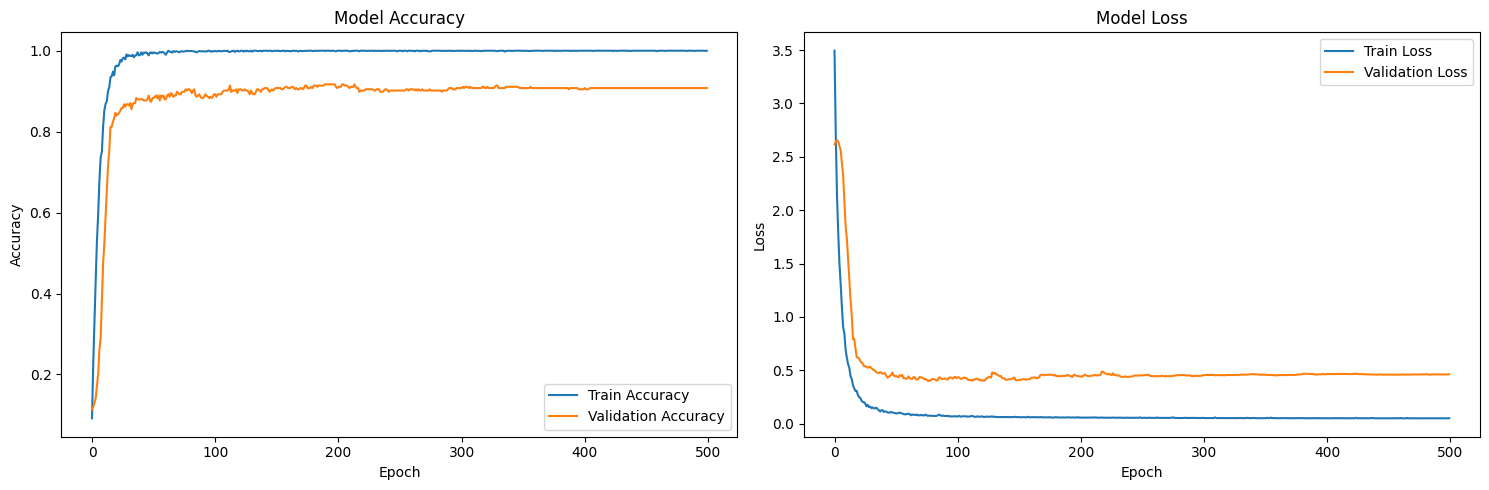


Evaluating model on validation data...
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 503ms/step - accuracy: 0.8226 - loss: 0.7630
Validation Loss: 0.7639
Validation Accuracy: 0.8123


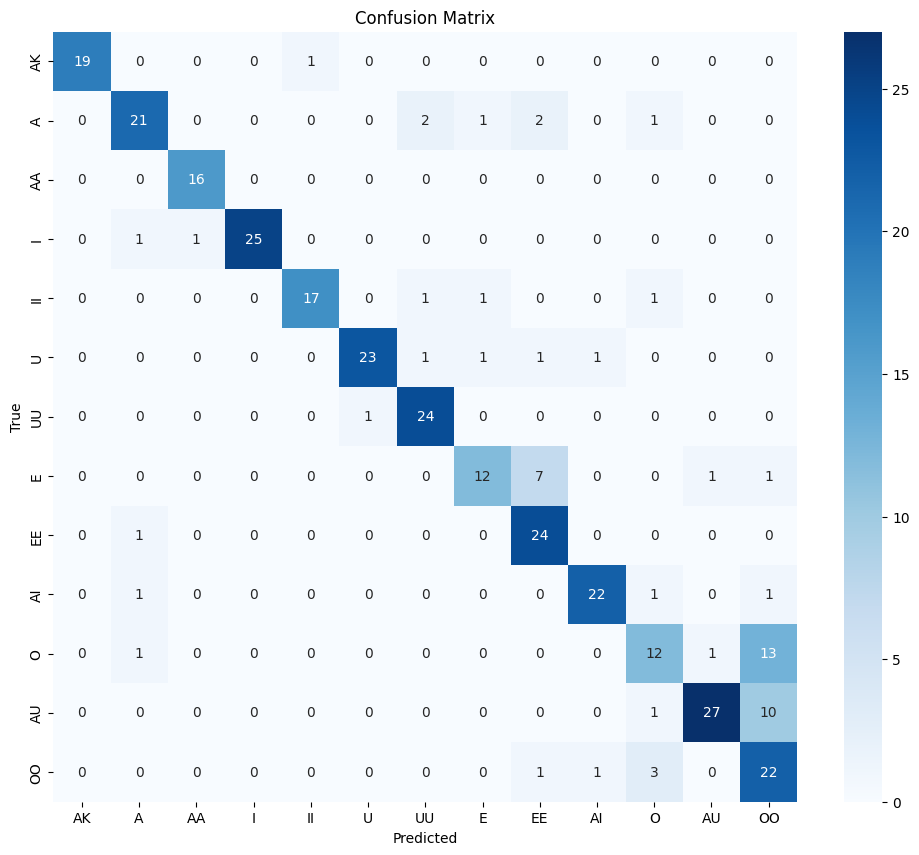


Classification Report:
              precision    recall  f1-score   support

          AK     1.0000    0.9500    0.9744        20
           A     0.8400    0.7778    0.8077        27
          AA     0.9412    1.0000    0.9697        16
           I     1.0000    0.9259    0.9615        27
          II     0.9444    0.8500    0.8947        20
           U     0.9583    0.8519    0.9020        27
          UU     0.8571    0.9600    0.9057        25
           E     0.8000    0.5714    0.6667        21
          EE     0.6857    0.9600    0.8000        25
          AI     0.9167    0.8800    0.8980        25
           O     0.6316    0.4444    0.5217        27
          AU     0.9310    0.7105    0.8060        38
          OO     0.4681    0.8148    0.5946        27

    accuracy                         0.8123       325
   macro avg     0.8442    0.8228    0.8233       325
weighted avg     0.8396    0.8123    0.8150       325



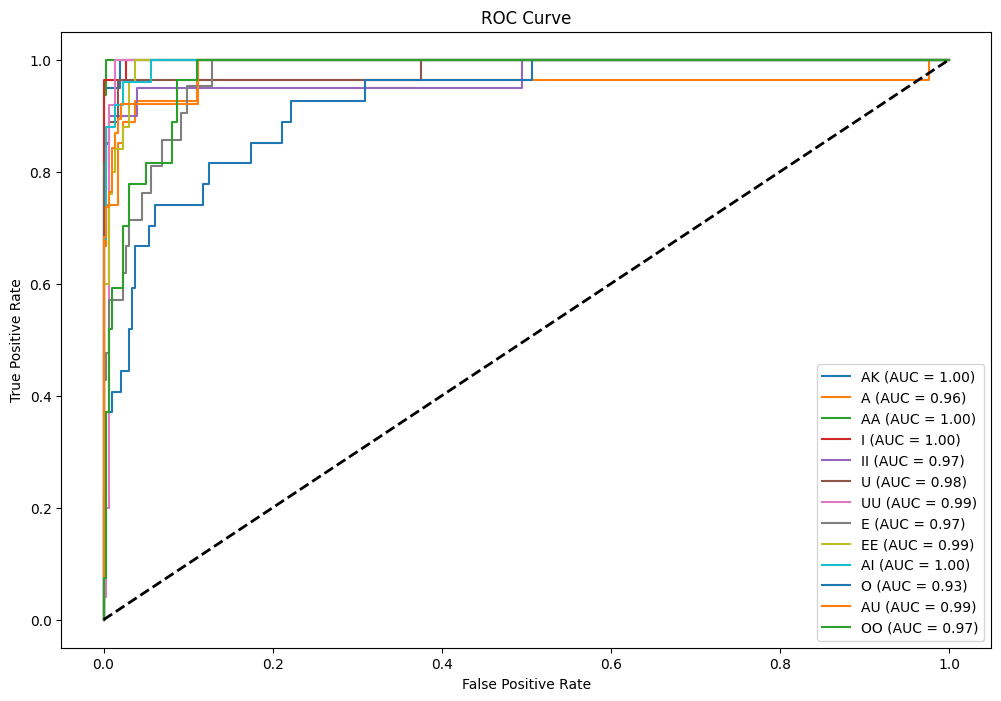

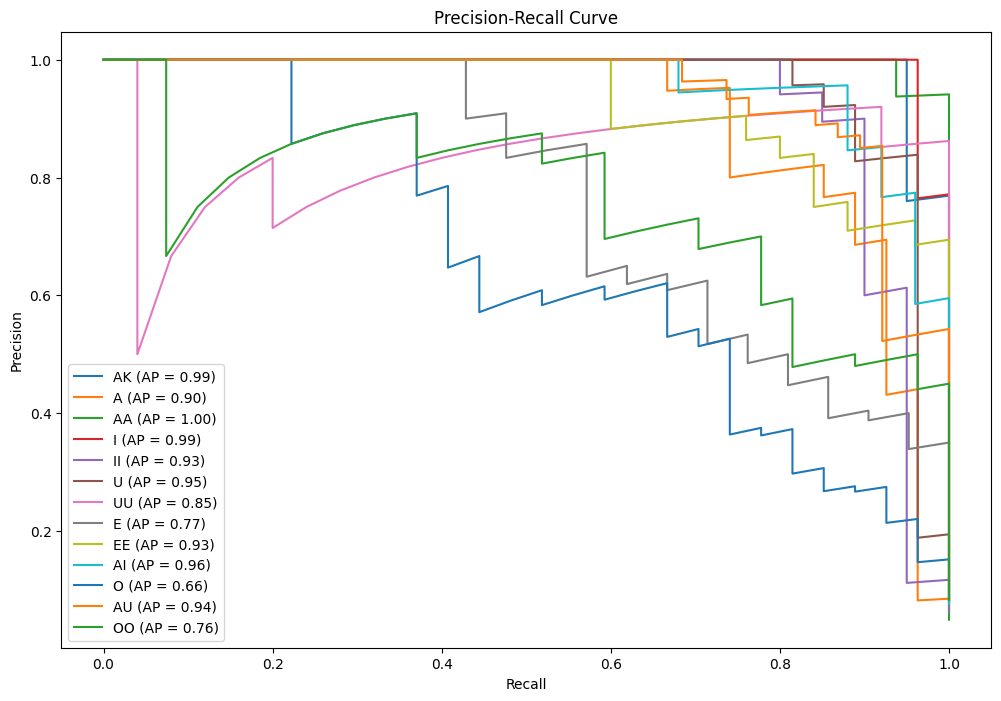

In [18]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
 
model = tf.keras.models.load_model('model.keras')
with open("training_history.pkl", "rb") as f:
    history = pickle.load(f)
 
dataset_path = "/kaggle/input/custom-dataset/custom dataset"
img_size = (224, 224)
batch_size = 32

 
def load_dataset():
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.2,
        subset="validation",
        seed=42,
        label_mode='int'
    )
    val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
    return val_dataset

val_dataset = load_dataset()


#  1. Training Curves (Accuracy & Loss) 
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

#  2. Model Evaluation 
print("\nEvaluating model on validation data...")
evaluation = model.evaluate(val_dataset)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

#  3. Confusion Matrix & Classification Report
def evaluate_model(model, dataset):
    y_true = []
    y_pred = []
    y_pred_prob = []
    
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
        y_pred_prob.extend(preds)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    return np.array(y_true), np.array(y_pred), np.array(y_pred_prob)

y_true, y_pred, y_pred_prob = evaluate_model(model, val_dataset)

#  4. ROC Curve & AUC  
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

#  5. Precision-Recall Curve  
plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('precision_recall_curve.png')
plt.show()


In [19]:
 
X_val = []
y_val = []

for images, labels in val_dataset:
    X_val.extend(images.numpy())  
    y_val.extend(labels.numpy())

X_val = np.array(X_val)
y_val = np.array(y_val)  


In [17]:
import pandas as pd

 
metrics_table = pd.DataFrame({
    'Epoch': range(1, len(history['accuracy']) + 1),
    'Train Accuracy': history['accuracy'],
    'Val Accuracy': history['val_accuracy'],
    'Train Loss': history['loss'],
    'Val Loss': history['val_loss']
})

 
selected_epochs = range(50, len(history['accuracy']) + 1, 50)
filtered_table = metrics_table[metrics_table['Epoch'].isin(selected_epochs)]
 
print("Epoch-wise Metrics (Selected Epochs):")
print(filtered_table.to_markdown(index=False))


Epoch-wise Metrics (Selected Epochs):
|   Epoch |   Train Accuracy |   Val Accuracy |   Train Loss |   Val Loss |
|--------:|-----------------:|---------------:|-------------:|-----------:|
|      50 |         0.993077 |       0.883077 |    0.0994331 |   0.443215 |
|     100 |         0.999231 |       0.892308 |    0.0665912 |   0.425993 |
|     150 |         0.999231 |       0.907692 |    0.0624042 |   0.407625 |
|     200 |         1        |       0.907692 |    0.0565712 |   0.442941 |
|     250 |         1        |       0.901538 |    0.0540753 |   0.45212  |
|     300 |         0.999231 |       0.907692 |    0.0548589 |   0.454808 |
|     350 |         1        |       0.907692 |    0.0521073 |   0.459725 |
|     400 |         1        |       0.904615 |    0.0510125 |   0.463467 |
|     450 |         1        |       0.907692 |    0.0506835 |   0.458921 |
|     500 |         1        |       0.907692 |    0.0509917 |   0.462307 |


In [4]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
 
model = tf.keras.models.load_model('/kaggle/input/se-cbam-effb0/model.keras')
with open("/kaggle/input/se-cbam-effb0/training_history.pkl", "rb") as f:
    history = pickle.load(f)

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

 
test_path = "/kaggle/input/testnew/test"
 
raw_test_dataset = image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    label_mode='int'
)

class_names = raw_test_dataset.class_names 
test_dataset = raw_test_dataset.prefetch(tf.data.AUTOTUNE)


Found 195 files belonging to 13 classes.


In [8]:
y_true = []
y_pred = []

for batch_images, batch_labels in test_dataset:
    preds = model.predict(batch_images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


I0000 00:00:1744723620.437704      81 service.cc:148] XLA service 0x7e1a3400efb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744723620.438616      81 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1744723623.407414      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step


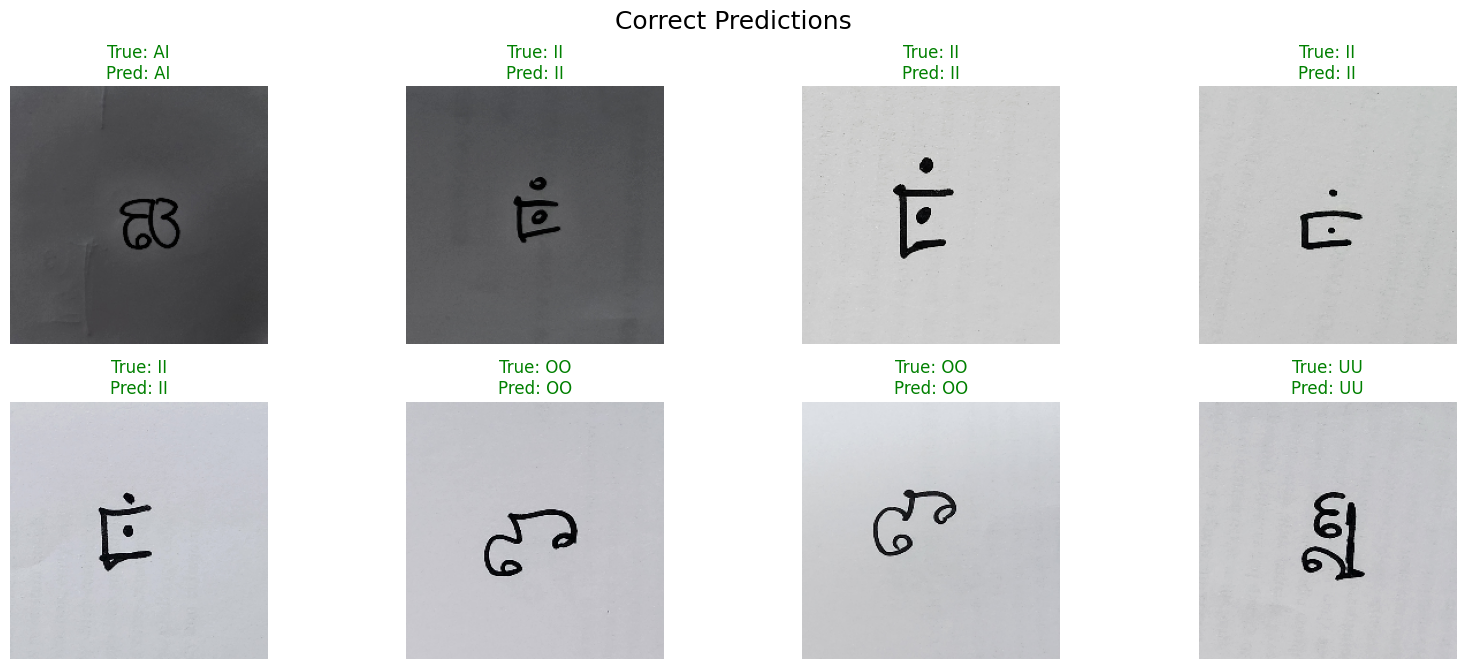

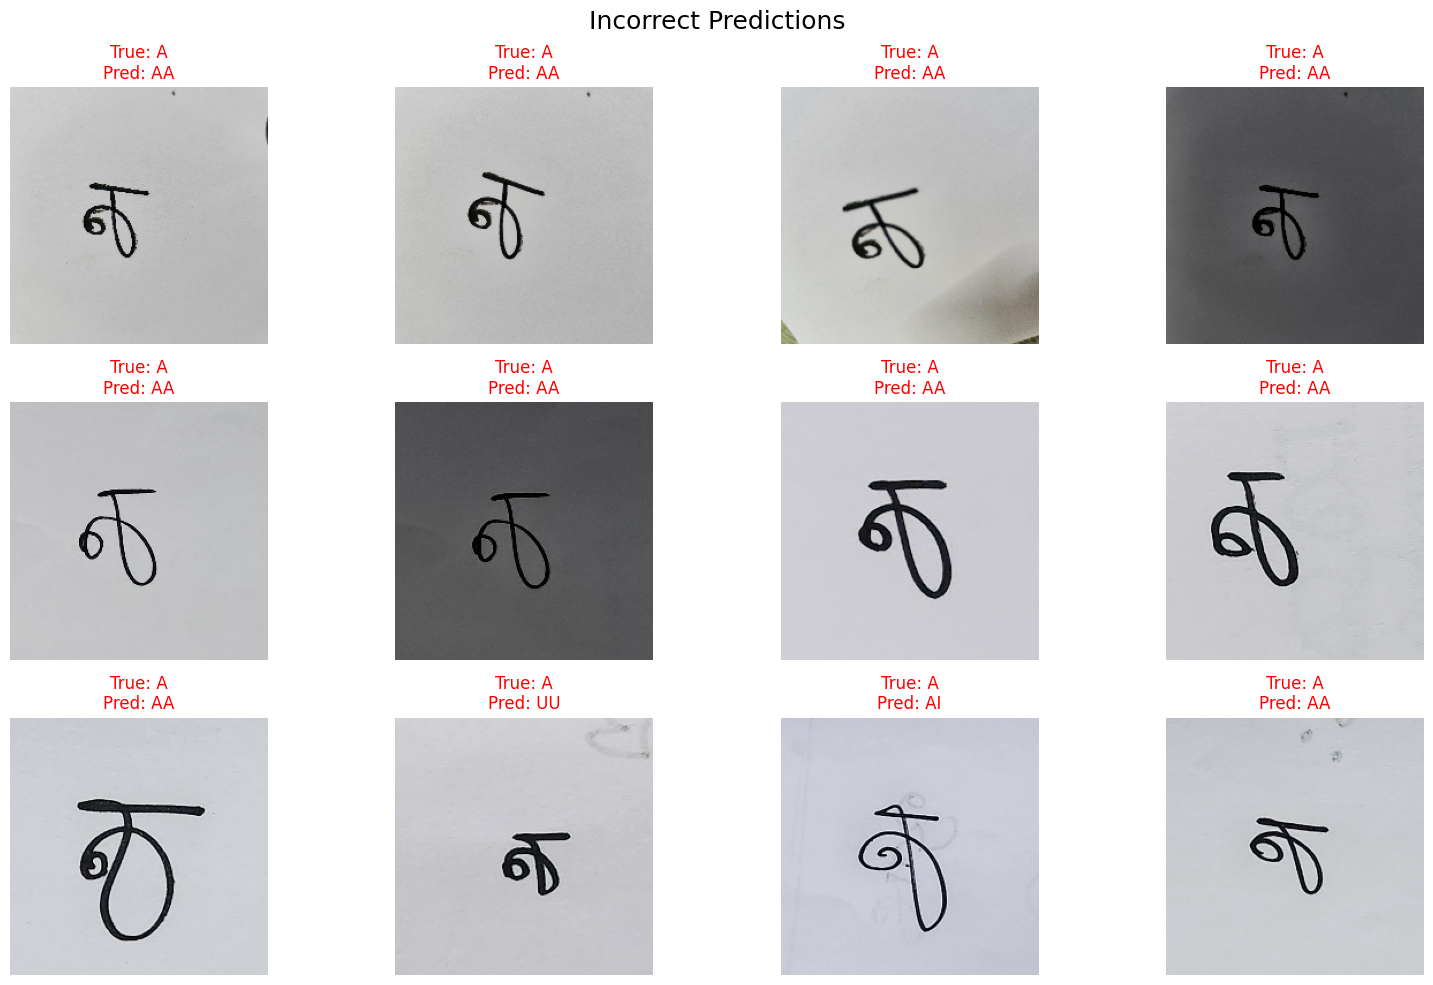

In [13]:
import matplotlib.pyplot as plt
import os

 
image_list = []
label_list = []

for images, labels in raw_test_dataset:
    image_list.append(images.numpy())
    label_list.append(labels.numpy())

images_all = np.concatenate(image_list)
labels_all = np.concatenate(label_list)
 
pred_probs = model.predict(images_all, batch_size=batch_size)
pred_classes = np.argmax(pred_probs, axis=1)
 
class_names = sorted(os.listdir("/kaggle/input/testnew/test"))

 
def display_predictions(indices, title, num_images=12):
    plt.figure(figsize=(16, 10))
    for i, idx in enumerate(indices[:num_images]):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images_all[idx].astype("uint8"))
        true_label = class_names[labels_all[idx]]
        pred_label = class_names[pred_classes[idx]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

 
correct_idx = np.where(pred_classes == labels_all)[0]
incorrect_idx = np.where(pred_classes != labels_all)[0]

 
display_predictions(correct_idx, "Correct Predictions")
display_predictions(incorrect_idx, "Incorrect Predictions")


195/195 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step


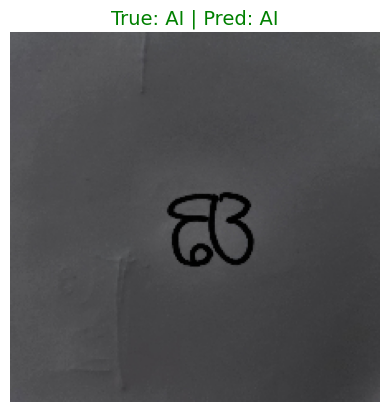

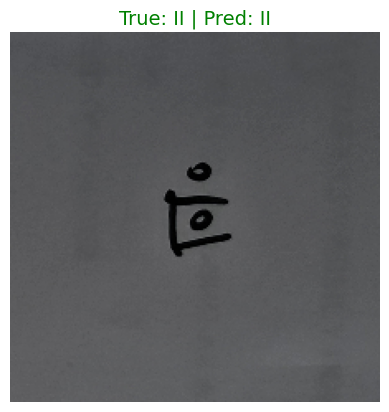

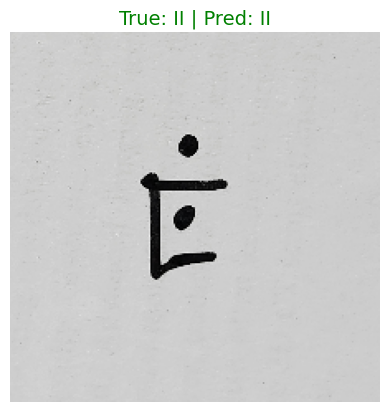

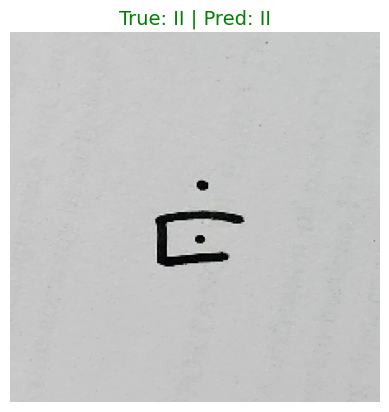

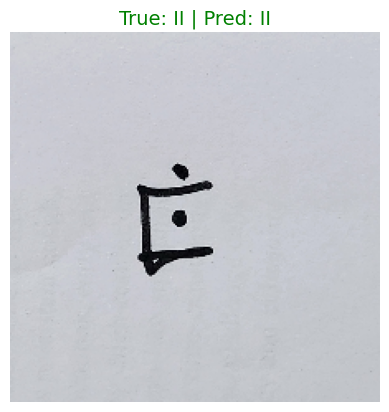

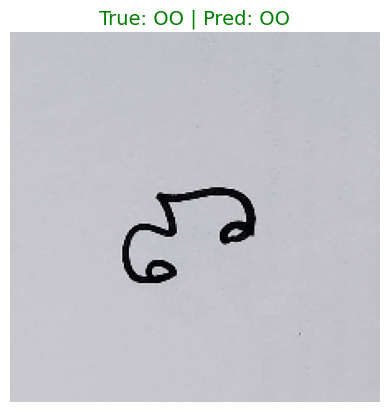

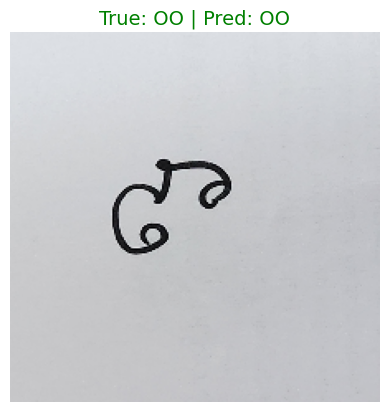

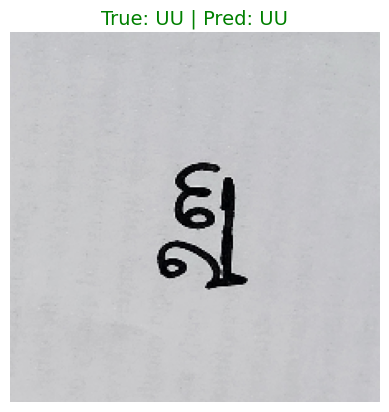

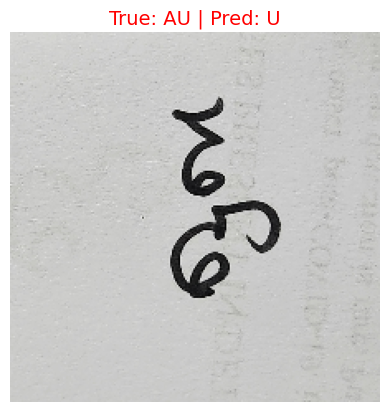

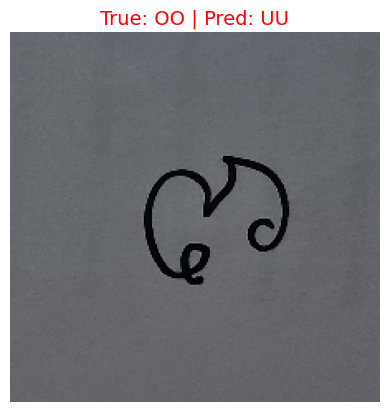

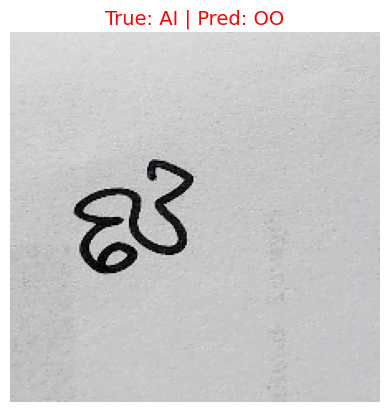

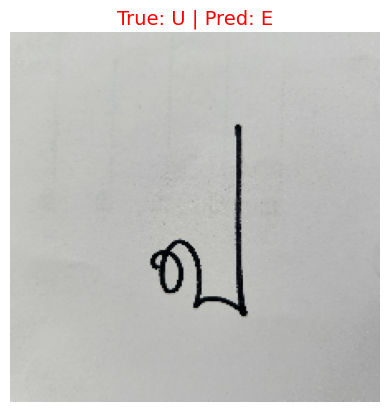

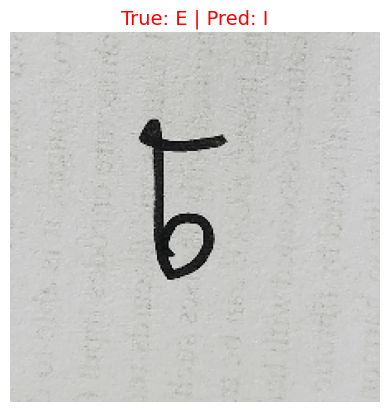

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

image_list = []
label_list = []

for images, labels in raw_test_dataset:
    image_list.append(images.numpy())
    label_list.append(labels.numpy())

images_all = np.concatenate(image_list)
labels_all = np.concatenate(label_list)

pred_probs = model.predict(images_all, batch_size=1)
pred_classes = np.argmax(pred_probs, axis=1)

class_names = sorted(os.listdir("/kaggle/input/testnew/test"))

correct_indices = np.where(pred_classes == labels_all)[0]
incorrect_indices = np.where(pred_classes != labels_all)[0]
sampled_incorrect = random.sample(list(incorrect_indices), min(5, len(incorrect_indices)))

for i in correct_indices:
    plt.imshow(images_all[i].astype("uint8"))
    true_label = class_names[labels_all[i]]
    pred_label = class_names[pred_classes[i]]
    plt.title(f"True: {true_label} | Pred: {pred_label}", color="green", fontsize=14)
    plt.axis("off")
    plt.show()

for i in sampled_incorrect:
    plt.imshow(images_all[i].astype("uint8"))
    true_label = class_names[labels_all[i]]
    pred_label = class_names[pred_classes[i]]
    plt.title(f"True: {true_label} | Pred: {pred_label}", color="red", fontsize=14)
    plt.axis("off")
    plt.show()
